# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from tqdm.auto import tqdm

c:\Users\roman\repos-roman\bert\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
# Las siguientes líneas son para convertir las columnas a los tipos de datos adecuados en caso de ser necesarias debido a que inducirian datos faltantes y podria llegar a tener que dropearlos
#df_reviews['end_year'] = df_reviews['end_year'].replace('\\N', pd.NA).astype('Int64')
#df_reviews['runtime_minutes'] = df_reviews['runtime_minutes'].replace('\\N', pd.NA).astype('Int64')


In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,47329.0,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,25562.917323,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,83670.039163,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.0,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,827.0,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3197.0,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,13974.0,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1739448.0,10.000000,1.000000,12499.000000


In [8]:
df_reviews.duplicated().sum()

np.int64(0)

In [9]:
df_reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [10]:
# Reemplaza los valores NaN por 8 y cuenta cuántos valores fueron reemplazados debido a que lei las reseñas y eran buenas
num_replaced = df_reviews['average_rating'].isna().sum()
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(8)
print(num_replaced)

2


### Exploracion inicial de datos 
- Sin datos nulos, ni duplicados, eso si con tipos de datos incorrectos en la longitud de la pelicula y año de finalizacion, aunque los considero inaportantes a la hora de concebir el modelo asi que muy probablemente las voy a apartar de los datos de entrenamiento.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

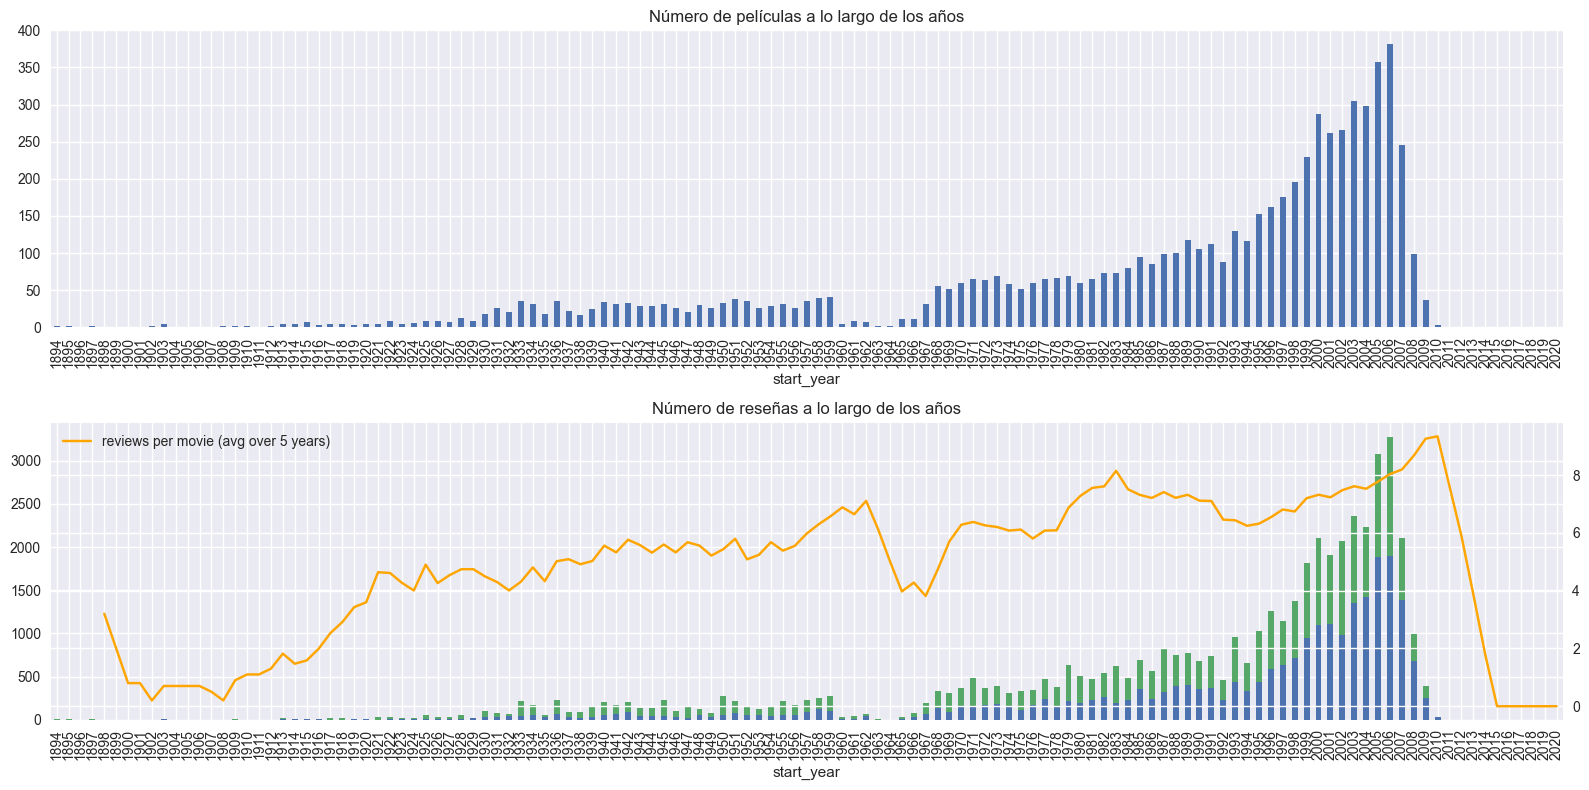

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

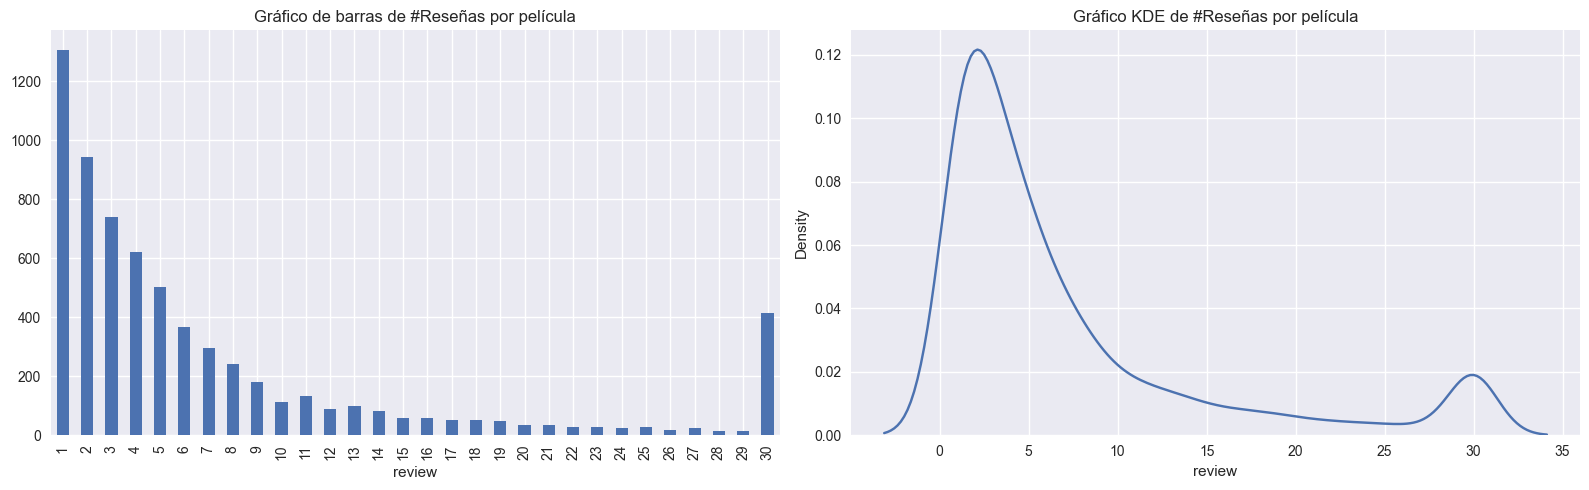

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

In [13]:
df_reviews['pos'].value_counts()

pos
0    23715
1    23616
Name: count, dtype: int64

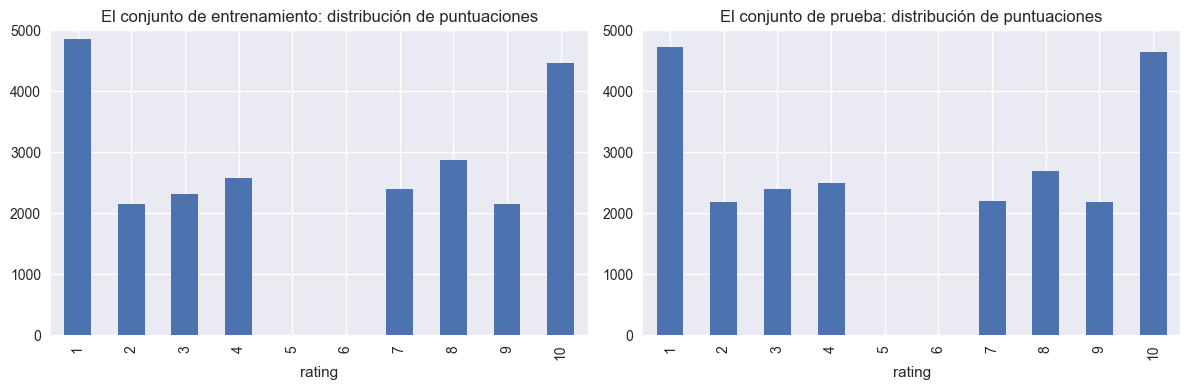

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

C:\Users\roman\AppData\Local\Temp\ipykernel_20804\1324160450.py:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\roman\AppData\Local\Temp\ipykernel_20804\1324160450.py:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
C:\Users\roman\AppData\Local\Temp\ipykernel_20804\1324160450.py:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
C:\Users\roman\AppData\Local\Temp\ipykernel_20804\1324160450.py:31: UserWarning: 

Support for a

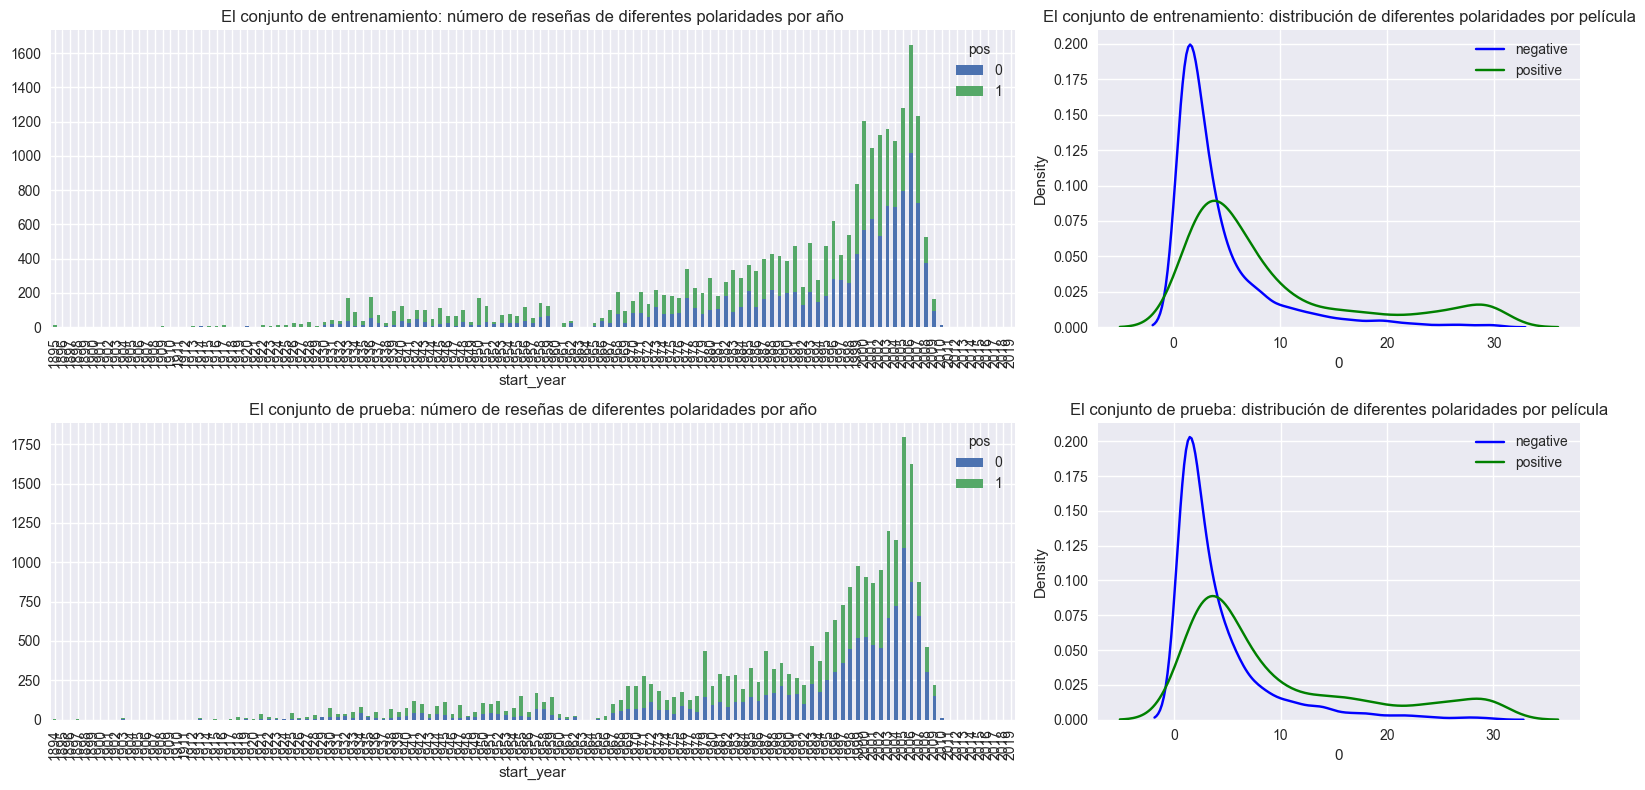

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [16]:

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'Curva ROC')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [17]:



df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace(r'[^a-z0-9\s]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()



## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [18]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Trabajar con modelos

### Modelo 0 - Constante

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


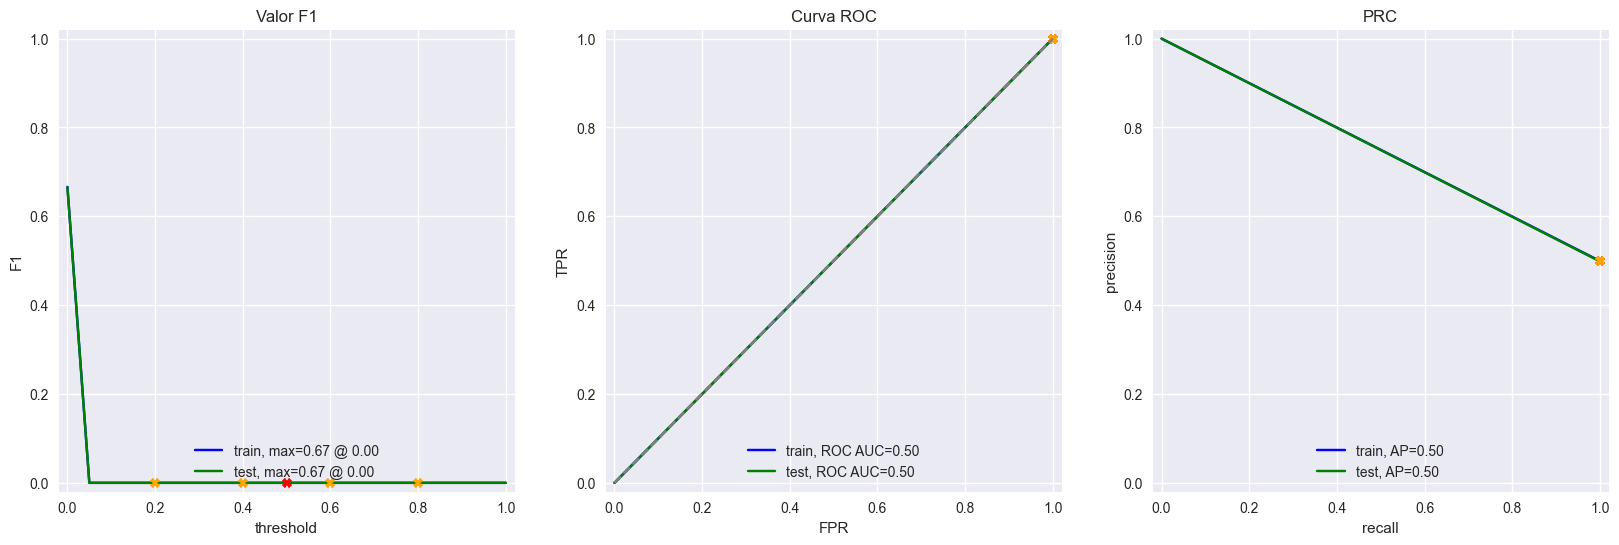

In [19]:
from sklearn.dummy import DummyClassifier
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(df_reviews_train['review_norm'], train_target)
evaluate_model(dummy_model, df_reviews_train['review_norm'], train_target, df_reviews_test['review_norm'], test_target)


### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [20]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\roman\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:

STOPWORDS = set(stopwords.words('english'))

df_reviews['review_norm'] = df_reviews['review_norm'].progress_apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS])) 
df_reviews['review_norm']

100%|██████████| 47331/47331 [00:01<00:00, 34782.23it/s]


0        pakage implies warren beatty goldie hawn pulli...
1        hell get made presenting caper comedy misbegot...
2        real story film seems like fly wall drama docu...
3        um serious film troubled teens singapore count...
4        totally agree garryjohal singapore comments fi...
                               ...                        
47326    another favorite columbos sports top notch cas...
47327    talk boring got expecting fascinating insight ...
47328    never thought say biopic near abundance charac...
47329    spirit chaos artistic biopic miyazawa kenji ja...
47330    make brief joy watch may may effective charact...
Name: review_norm, Length: 47331, dtype: object

In [63]:
count_tf_idf = TfidfVectorizer(stop_words=list(STOPWORDS))
X_train_tf_idf = count_tf_idf.fit_transform(df_reviews_train['review_norm'])
X_test_tf_idf = count_tf_idf.transform(df_reviews_test['review_norm'])  
X_train_tf_idf.shape, X_test_tf_idf.shape



((23796, 72697), (23535, 72697))

In [24]:
model_a = LogisticRegression(max_iter=1000, random_state=12345)
model_a.fit(X_train_tf_idf, df_reviews_train['pos'])

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,12345
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


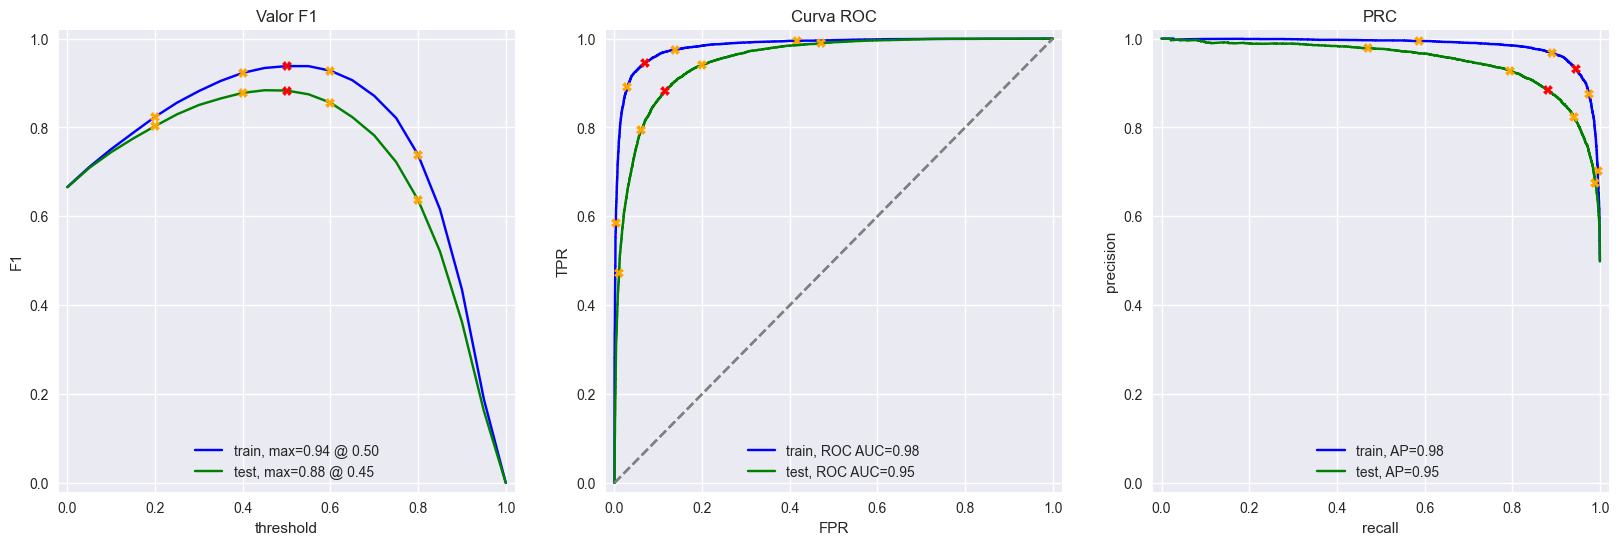

In [25]:
evaluate_model(model_a, X_train_tf_idf, df_reviews_train['pos'], X_test_tf_idf, df_reviews_test['pos'])

### Modelo 3 - spaCy, TF-IDF y LR (con XGBoost)

In [26]:
import spacy

# Download the model if not already present
try:
	nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
except OSError:
	from spacy.cli import download
	download('en_core_web_sm')
	nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [27]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [28]:
print("Lematizando textos...")
df_reviews['review_lemmatized'] = df_reviews['review_norm'].apply(text_preprocessing_3)

Lematizando textos...


In [29]:
df_reviews['review_lemmatized']

0        pakage imply warren beatty goldie hawn pull hu...
1        hell get make presenting caper comedy misbegot...
2        real story film seem like fly wall drama docum...
3        um serious film troubled teen singapore countr...
4        totally agree garryjohal singapore comment fil...
                               ...                        
47326    another favorite columbos sport top notch cast...
47327    talk boring get expect fascinating insight lif...
47328    never think say biopic near abundance characte...
47329    spirit chaos artistic biopic miyazawa kenji ja...
47330    make brief joy watch may may effective charact...
Name: review_lemmatized, Length: 47331, dtype: object

In [30]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()  

In [67]:
count_tf_idf_b = TfidfVectorizer(stop_words=list(STOPWORDS))
X_train_tf_idf_spa = count_tf_idf_b.fit_transform(df_reviews_train['review_lemmatized'])
X_test_tf_idf_spa = count_tf_idf_b.transform(df_reviews_test['review_lemmatized'])


In [68]:
model_spa = XGBClassifier(n_estimators=100, max_depth=6, random_state=12345, use_label_encoder=False, eval_metric='logloss')
model_spa.fit(X_train_tf_idf_spa, df_reviews_train['pos'])

c:\Users\roman\repos-roman\bert\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:31:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


          train  test
Accuracy   0.94  0.85
F1         0.95  0.85
APS        0.99  0.93
ROC AUC    0.99  0.93


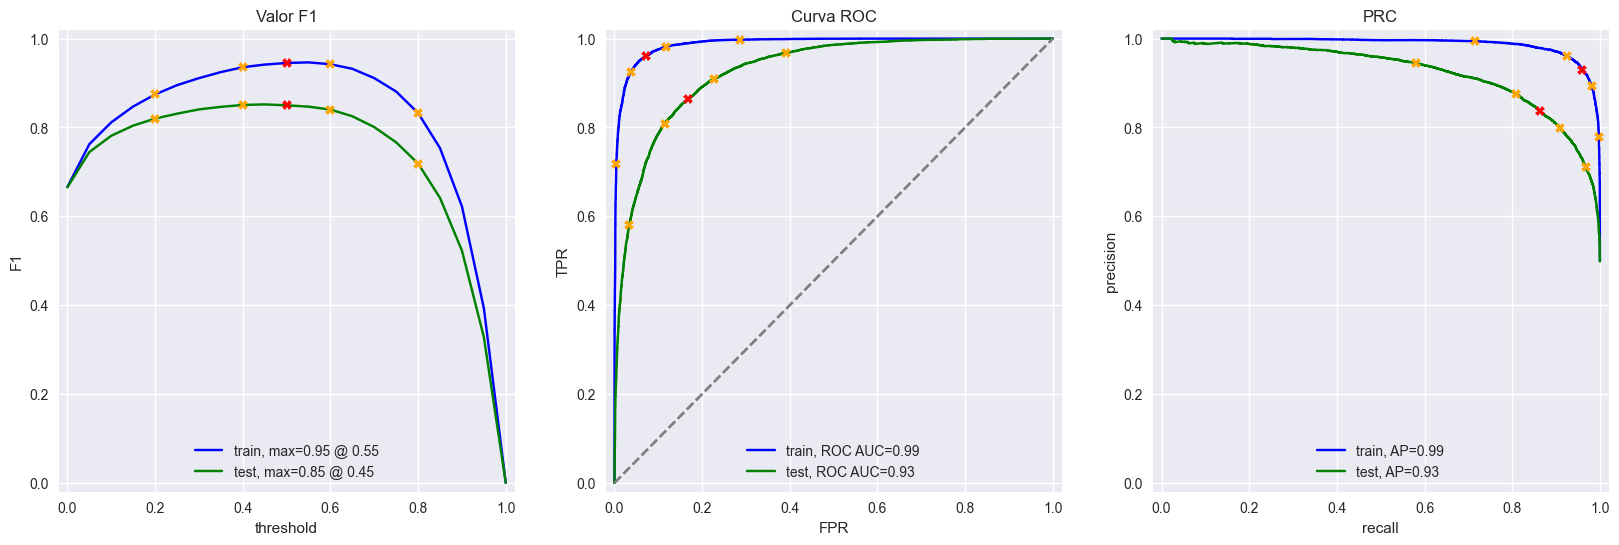

In [33]:
evaluate_model(model_spa, X_train_tf_idf_spa, df_reviews_train['pos'], X_test_tf_idf_spa, df_reviews_test['pos'])   

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [34]:
from lightgbm import LGBMClassifier

In [35]:
model_l = LGBMClassifier(n_estimators=100, max_depth=6, random_state=12345)
model_l.fit(X_train_tf_idf_spa, df_reviews_train['pos'])

[LightGBM] [Info] Number of positive: 11884, number of negative: 11912
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.319410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 460350
[LightGBM] [Info] Number of data points in the train set: 23796, number of used features: 9554
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499412 -> initscore=-0.002353
[LightGBM] [Info] Start training from score -0.002353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,6
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


c:\Users\roman\repos-roman\bert\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\roman\repos-roman\bert\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\roman\repos-roman\bert\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\roman\repos-roman\bert\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


          train  test
Accuracy   0.88  0.83
F1         0.88  0.84
APS        0.95  0.91
ROC AUC    0.95  0.91


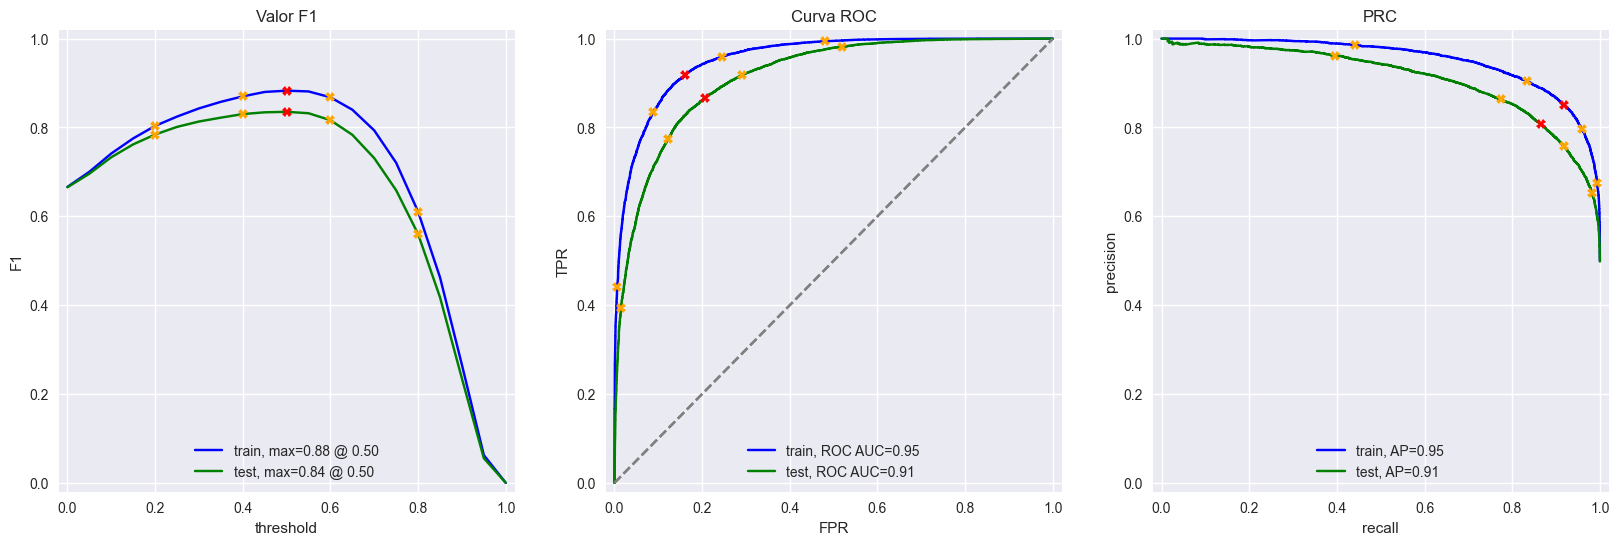

In [36]:
evaluate_model(model_l, X_train_tf_idf_spa, df_reviews_train['pos'], X_test_tf_idf_spa, df_reviews_test['pos'])

###  Modelo 9 - BERT

In [37]:
import torch
import transformers

In [38]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [39]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    """
    Convierte textos a embeddings usando BERT
    
    Args:
        texts: Lista de textos a procesar
        max_length: Longitud máxima de tokens
        batch_size: Tamaño del lote para procesamiento
        force_device: Forzar dispositivo ('cuda' o 'cpu')
        disable_progress_bar: Desactivar barra de progreso
    
    Returns:
        Array numpy con los embeddings de los textos
    """
    
    # Cargar tokenizer y modelo BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    
    ids_list = []
    attention_mask_list = []

    # Tokenizar textos y crear IDs y máscaras de atención
    for text in texts:
        # Tokenizar el texto
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        ids_list.append(encoded['input_ids'].squeeze().numpy())
        attention_mask_list.append(encoded['attention_mask'].squeeze().numpy())

    # Configurar dispositivo
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')

    # Obtener embeddings en lotes
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
        # Preparar batch
        start_idx = batch_size * i
        end_idx = batch_size * (i + 1)
        
        ids_batch = torch.LongTensor(ids_list[start_idx:end_idx]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[start_idx:end_idx]).to(device)

        # Obtener embeddings
        with torch.no_grad():
            model.eval()
            outputs = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
            # Usar el embedding del token [CLS] (primera posición)
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        
        embeddings.append(batch_embeddings.detach().cpu().numpy())
    
    if len(embeddings) == 0:
        return np.array([]) 
    
    return np.concatenate(embeddings)

In [40]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'][:1001], force_device='cpu')
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'][:1001], force_device='cpu')

Uso del dispositivo cpu.


  0%|          | 0/11 [00:00<?, ?it/s]C:\Users\roman\AppData\Local\Temp\ipykernel_20804\778464108.py:57: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  ids_batch = torch.LongTensor(ids_list[start_idx:end_idx]).to(device)
100%|██████████| 11/11 [05:33<00:00, 30.28s/it]


Uso del dispositivo cpu.


100%|██████████| 11/11 [05:26<00:00, 29.66s/it]


In [41]:
train_target_9 = df_reviews_train['pos'][:1001]
test_target_9 = df_reviews_test['pos'][:1001]

In [42]:
with np.load('features_9.npz') as data:
    train_features_9 = data['train_features_9']
    test_features_9 = data['test_features_9']

In [43]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(1001, 768)
(23796,)


In [44]:
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

In [45]:
train_features_9 

array([[-0.32569247,  0.06980264,  0.13385765, ..., -0.4515187 ,
         0.40556893,  0.21170418],
       [-0.2545132 ,  0.06275611,  0.23630337, ..., -0.32547462,
         0.28782976,  0.06386247],
       [-0.39613014,  0.14304605, -0.2017027 , ..., -0.6273234 ,
         0.32776853,  0.30795643],
       ...,
       [-0.14669243,  0.23393095,  0.6739692 , ..., -0.36729422,
         0.44926932, -0.1158445 ],
       [-0.13330835,  0.30929407,  0.15298508, ..., -0.4169266 ,
         0.19522163,  0.26293212],
       [-0.02054784, -0.05394169,  0.532725  , ..., -0.51730454,
         0.23724762, -0.15900248]], shape=(1001, 768), dtype=float32)

In [46]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

In [47]:
model_b = LogisticRegression(max_iter=1000, random_state=12345)
model_b.fit(train_features_9, train_target_9)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,12345
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


          train  test
Accuracy   0.94  0.76
F1         0.94  0.74
APS        0.99  0.83
ROC AUC    0.99  0.83


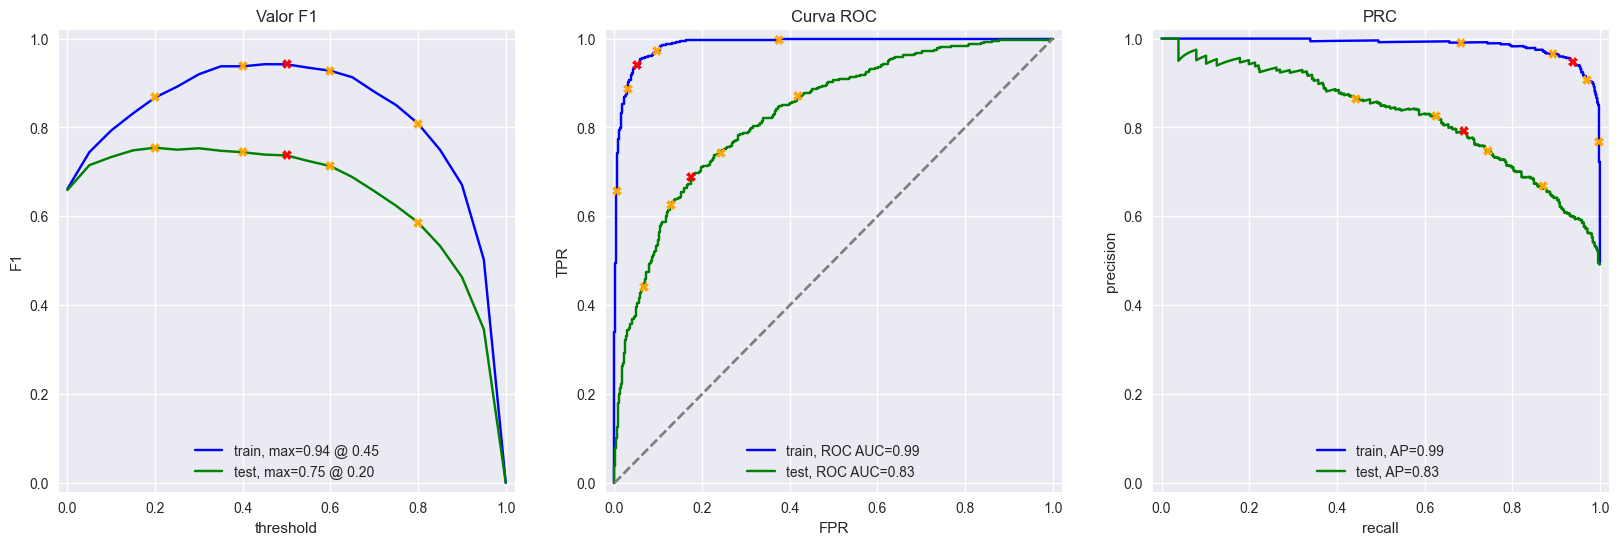

In [48]:
evaluate_model(model_b, train_features_9, train_target_9, test_features_9, test_target_9)

c:\Users\roman\repos-roman\bert\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:44:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


          train  test
Accuracy    1.0  0.73
F1          1.0  0.71
APS         1.0  0.82
ROC AUC     1.0  0.82


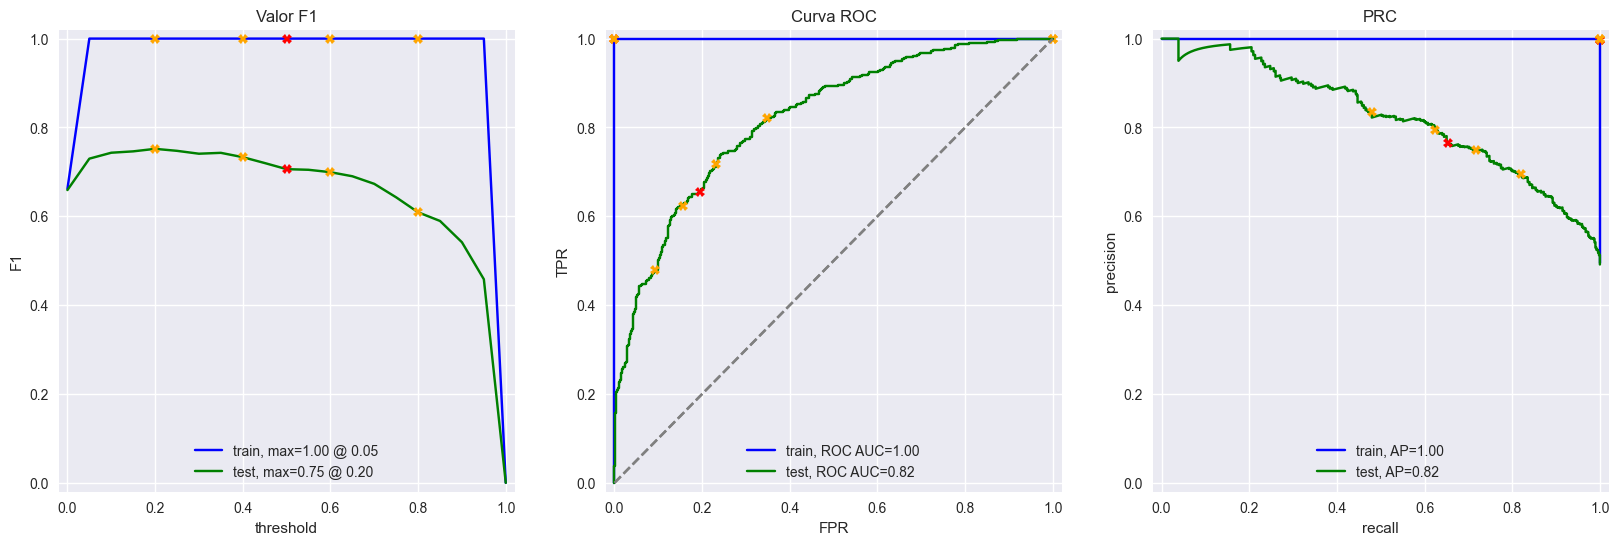

In [49]:
model_ba = XGBClassifier(n_estimators=100, max_depth=4, random_state=12345, use_label_encoder=False, eval_metric='logloss')
model_ba.fit(train_features_9, train_target_9)
evaluate_model(model_ba, train_features_9, train_target_9, test_features_9, test_target_9)

## Mis reseñas

In [50]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace(r'[^a-z0-9\s]', ' ', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
my_reviews['review_norm']
my_reviews['pos']=[0, 0, 1, 0, 1, 1, 0, 1]


In [51]:
STOPWORDS = set(stopwords.words('english'))

my_reviews['review_norma'] = my_reviews['review_norm'].progress_apply(lambda x: ' '.join([word for word in x.split() if word not in STOPWORDS])) 
my_reviews['review_norma']
texts = my_reviews['review_norma']

100%|██████████| 8/8 [00:00<00:00, 19119.33it/s]


### Modelo 2 NLTK, TF-IDF y LR

In [64]:
texts = my_reviews['review_norm']

#count_tf_idf = TfidfVectorizer(max_features=72697)

X_test_a = count_tf_idf.transform(texts)
X_test_a.shape


(8, 72697)

##### Accuracy Modelo LR usando TF-IDF (Modelo 1)

Accuracy model_a: 0.75   
          train  test
Accuracy   0.94  0.75
F1         0.94  0.67
APS        0.98  1.00
ROC AUC    0.98  1.00


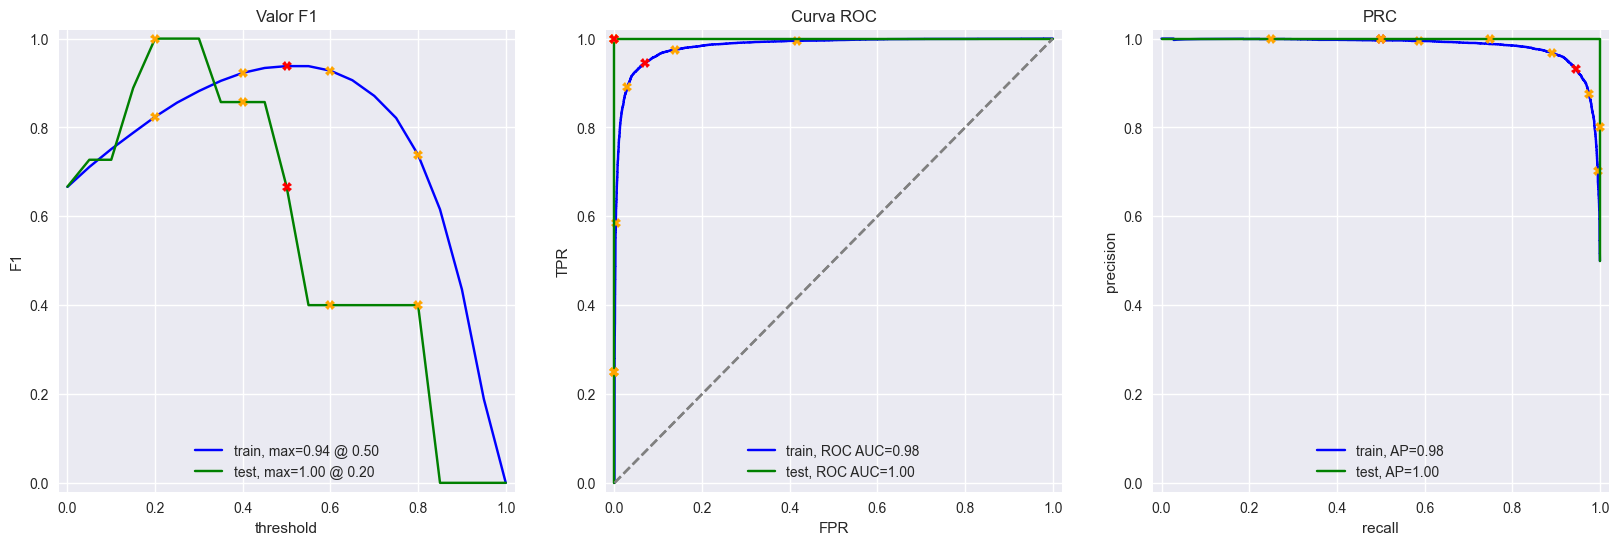

In [ ]:
sal_test_a = model_a.predict(X_test_a)
#print(f'Accuracy model_a: {metrics.accuracy_score(my_reviews["pos"], sal_test_a):.2f}   ')
evaluate_model(model_a, X_train_tf_idf, df_reviews_train['pos'], X_test_a, my_reviews['pos'])

#### Accuracy modelo LR usando spacy (Modelo 2)

In [69]:

my_reviews['review_lemmatized'] = my_reviews['review_norm'].apply(text_preprocessing_3)



In [70]:
texts = my_reviews['review_lemmatized']

X_test_b = count_tf_idf_b.transform(texts)
X_test_b.shape

(8, 61524)

          train  test
Accuracy   0.94  0.88
F1         0.95  0.89
APS        0.99  0.95
ROC AUC    0.99  0.97


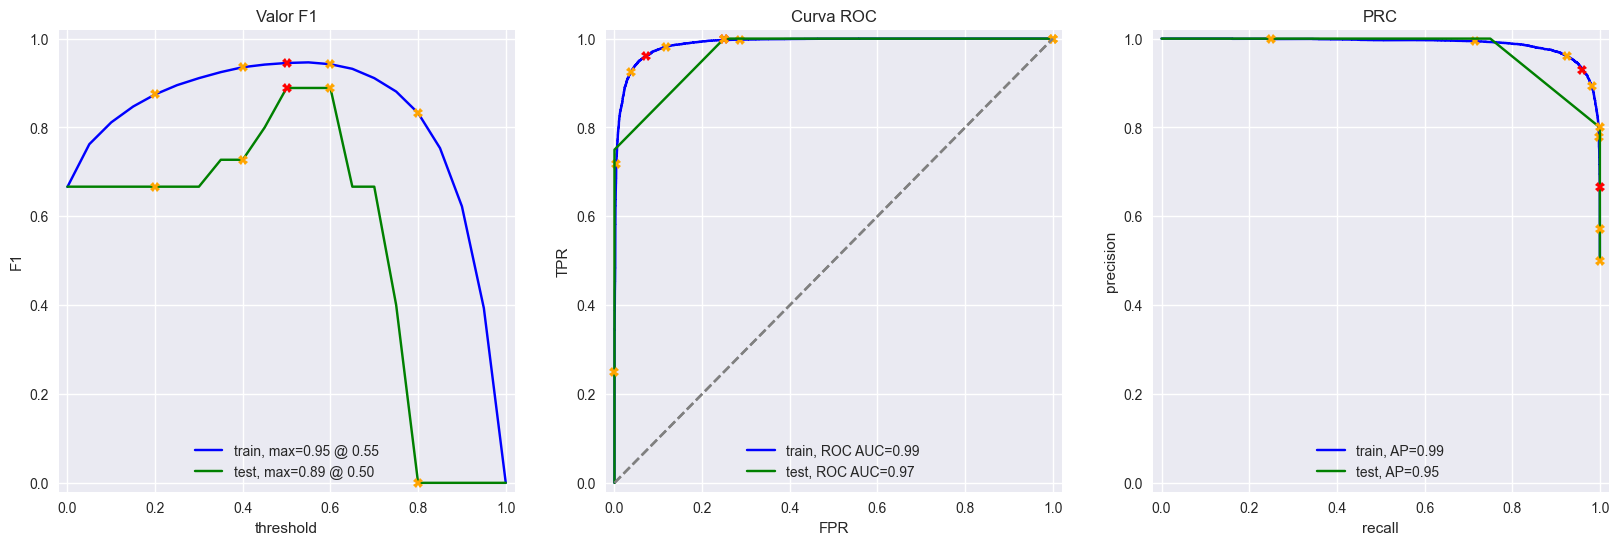

In [72]:
sal_test_b = model_spa.predict(X_test_b)
#print(f'Accuracy model_b: {metrics.accuracy_score(my_reviews["pos"], sal_test_b):.2f}   ')
evaluate_model(model_spa, X_train_tf_idf_spa, df_reviews_train['pos'], X_test_b, my_reviews['pos'])

#### Accuracy modelo BERT

In [74]:
text_bert = my_reviews['review_lemmatized']
X_test_c = BERT_text_to_embeddings(text_bert, force_device='cpu')
X_test_c.shape



Uso del dispositivo cpu.


100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


(8, 768)

          train  test
Accuracy    1.0  0.88
F1          1.0  0.86
APS         1.0  0.95
ROC AUC     1.0  0.94


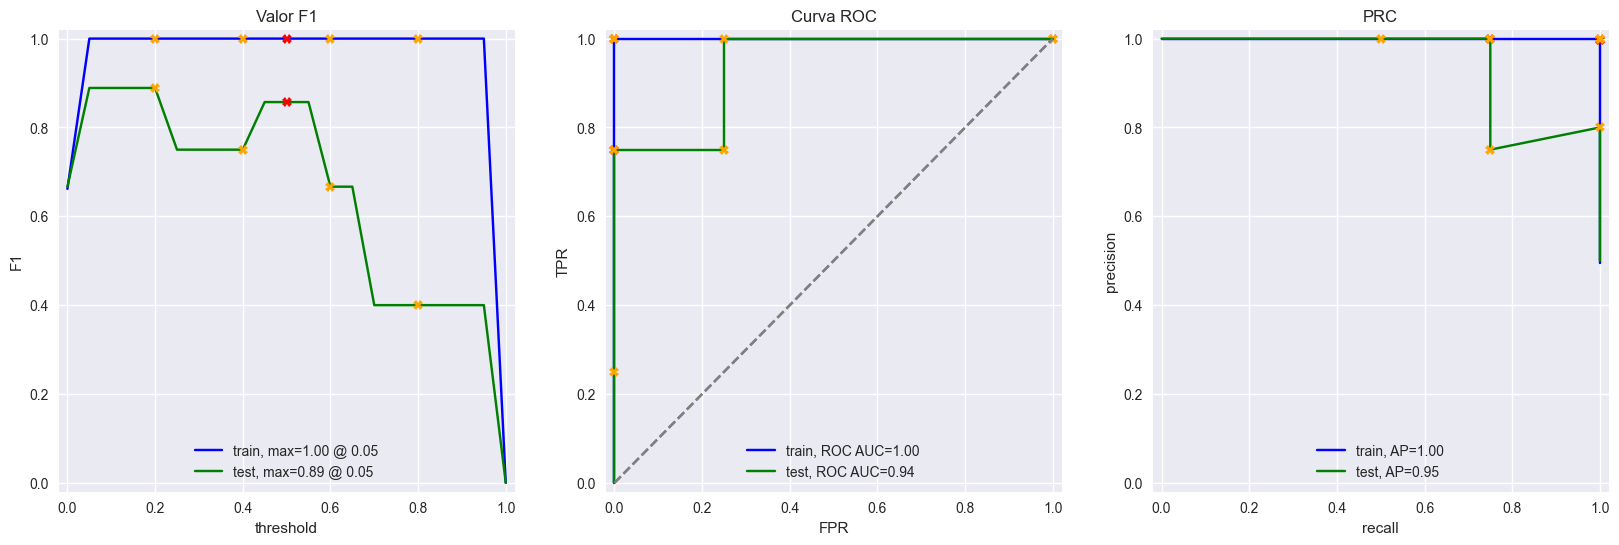

In [77]:
pred_bert = model_ba.predict(X_test_c)
evaluate_model(model_ba, train_features_9, train_target_9, X_test_c, my_reviews['pos'])

### Modelo 9

## Conclusiones

- Podemos concluir que todos los metodos funcionan digamos decentemente. 
- En la prueba con comentarios nuevos Bert y spacy tuvieron desempeño mejor al simple tf-idf
- En la realidad el BERT es mas utilizado para analizar textos con contexto, puesto que es mejor para esta tarea.
- El tf-idf pone peso a las palabras importantes asi que se destaca en busqueda de texto importante y/o buscar comentarios relevantes con cierto criterio.
- Sigue siendo importante elegir un buen modelo de ML a la par del metodo para vectorizar palabras.

# Lista de comprobación

- [x]  Abriste el notebook
- [ ]  Cargaste y preprocesaste los datos de texto para su vectorización
- [ ]  Transformaste los datos de texto en vectores
- [ ]  Entrenaste y probaste los modelos
- [ ]  Se alcanzó el umbral de la métrica
- [ ]  Colocaste todas las celdas de código en el orden de su ejecución
- [ ]  Puedes ejecutar sin errores todas las celdas de código
- [ ]  Hay conclusiones